# RAG

### ENV

In [11]:
import os
os.environ["OPENAI_BASE_URL"] = "https://api.openai-proxy.org/v1"
os.environ["OPENAI_API_KEY"] = "sk-660BMZI5WRTfL2XFM2ykCvJMbYiKYXahc4p98vPFxMzKf5jS"

### 1 Loader

##### 文字PDFLoader

In [19]:
from langchain_community.document_loaders import PyPDFLoader
file_path = 'asset/PDFLoader.pdf'
loader = PyPDFLoader(file_path)
# 异步加载 PDF 的每一页
pages = []
async for page in loader.alazy_load():
    pages.append(page)
print(f"Total pages loaded: {len(pages)}")
print(pages[0].metadata)
print(pages[0].page_content)

Total pages loaded: 1
{'producer': 'Microsoft® Word LTSC', 'creator': 'Microsoft® Word LTSC', 'creationdate': '2025-08-13T17:42:42+08:00', 'author': '超世 鲁', 'moddate': '2025-08-13T17:42:42+08:00', 'source': 'asset/PDFLoader.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}
1. 车牌识别 
采用“检测+识别”两阶段方案。通过高性能目标检测模型定位车牌区域，结
合专用OCR 模型实现字符解析。系统兼顾精度与效率，可适配嵌入式及边缘计
算场景。 
2. 无人机密集人员计数 
针对高空视角下目标小、密度高、环境复杂等问题，采用小目标增强技术
提升检测能力，结合多模态数据融合（如可见光与红外）增强夜间和复杂天气
下的鲁棒性。通过边缘-云端协同架构保障实时性，并探索多机协同与动态预测
能力。 
3. 漂浮物、火源、车辆类型识别 
漂浮物：基于高分辨率感知与小目标优化模型进行检测，结合跟踪与分割
提升稳定性。 
火源：采用动静态特征联合分析，结合时序信息与多光谱输入提升早期发
现能力。 
车辆分类：使用检测与细粒度分类级联架构，结合注意力机制与轨迹一致
性优化识别结果。 
部署与优化 
系统以 PyTorch为训练框架，通过模型压缩与推理加速技术（如量化、剪
枝等）实现高性能部署，支持在高端 GPU 或边缘设备上运行，满足实时性要
求。


#### 多模态模型解析PDF

In [20]:
import base64
import io, pymupdf

from PIL import Image

def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = pymupdf.open(pdf_path) # open a document
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

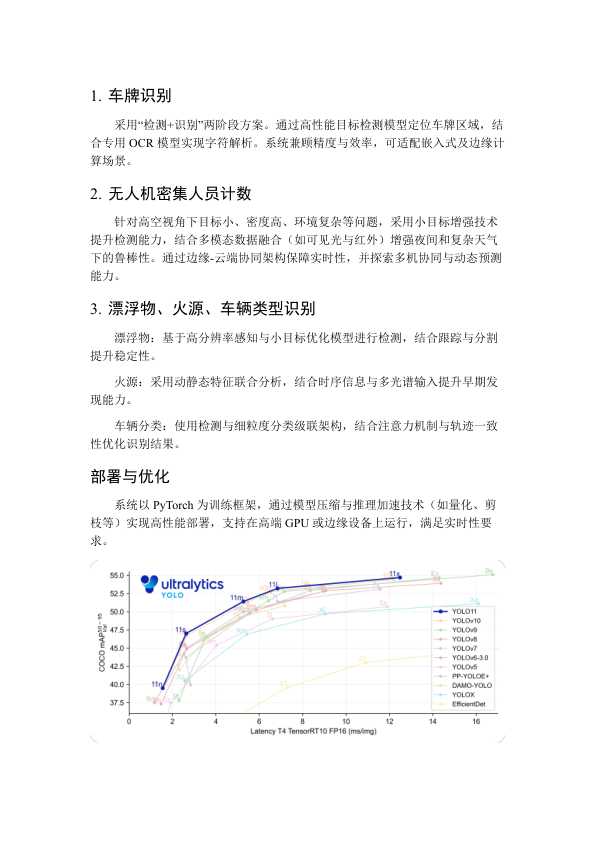

In [21]:
from IPython.display import Image as IPImage
from IPython.display import display
file_path = "asset/PDFLoader.pdf"
base64_image = pdf_page_to_base64(file_path, 1)
display(IPImage(data=base64.b64decode(base64_image)))

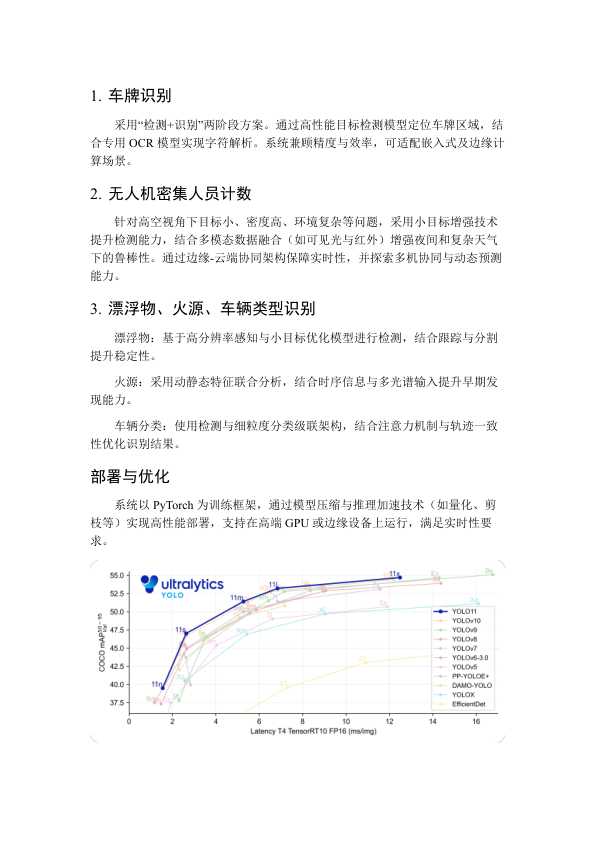

In [22]:
base64_image = pdf_page_to_base64(file_path, 1)
display(IPImage(data=base64.b64decode(base64_image)))

from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

In [23]:
from langchain_core.messages import HumanMessage

query = "如何车牌识别"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ]
)

response = llm.invoke([message])
print(response.content)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"


车牌识别是一种利用计算机视觉和深度学习技术来自动识别车辆牌照信息的技术。以下是车牌识别的一些关键步骤和技术要点：

1. **图像采集**：使用摄像头或其他图像采集设备获取车辆的图像，确保图像清晰且光照条件良好。

2. **预处理**：对采集到的图像进行预处理，包括去噪、增强对比度、调整亮度等，以提高后续处理的准确性。

3. **车牌定位**：通过图像处理算法（如边缘检测、轮廓提取等）定位车牌在图像中的位置。可以使用深度学习模型（如YOLO、SSD等）进行目标检测。

4. **字符分割**：在定位到车牌区域后，进一步对车牌中的字符进行分割，以便后续的字符识别。

5. **字符识别**：使用OCR（光学字符识别）技术对分割出的字符进行识别。可以使用深度学习模型（如CNN）来提高识别的准确率。

6. **结果输出**：将识别出的车牌信息进行格式化输出，可能还需要与数据库进行比对，以验证车牌的合法性。

7. **系统优化**：通过不断的训练和优化模型，提高识别的准确率和速度，适应不同的环境和条件。

在实际应用中，车牌识别系统可以集成到交通管理、停车场管理、收费系统等多个场景中，提升管理效率和安全性。


#### WebBaseLoader

In [24]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# 目标网页 URL
page_url = "https://python.langchain.com/docs/how_to/chatbots_memory/"

# 创建 WebBaseLoader 实例
loader = WebBaseLoader(web_paths=[page_url])

# 加载网页内容
docs = []
async for doc in loader.alazy_load():
    docs.append(doc)

# 确保加载的文档数量为 1
assert len(docs) == 1

# 获取第一个文档
doc = docs[0]
print(doc)

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  4.85it/s]

page_content='




How to add memory to chatbots | 🦜️🔗 LangChain








Skip to main contentOur Building Ambient Agents with LangGraph course is now available on LangChain Academy!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engineBuild a Question/Answering system over SQL dataSummarize TextHow-to guidesHow-to guidesHow to use tools in a chainHow to use a vectorstore as a retrieverHow to add memory to chatbotsHow to use example selectorsHow to add a semantic layer over graph databaseHow to invoke runnables in parallelHow to stream chat model responsesH

#### UnstructuredLoader

In [25]:
from langchain_unstructured import UnstructuredLoader

# 源网页 URL
page_url = "https://python.langchain.com/docs/how_to/chatbots_memory/"
loader = UnstructuredLoader(web_url=page_url) # 这里一定要指定 web_url=xxx

docs = []
async for doc in loader.alazy_load():
    docs.append(doc)

for doc in docs:
    print(doc.page_content)

Open In Colab
Open on GitHub
How to add memory to chatbots
A key feature of chatbots is their ability to use the content of previous conversational turns as context. This state management can take several forms, including:
Simply stuffing previous messages into a chat model prompt.
The above, but trimming old messages to reduce the amount of distracting information the model has to deal with.
More complex modifications like synthesizing summaries for long running conversations.
We'll go into more detail on a few techniques below!
note
This how-to guide previously built a chatbot using RunnableWithMessageHistory. You can access this version of the guide in the v0.2 docs.
As of the v0.3 release of LangChain, we recommend that LangChain users take advantage of LangGraph persistence to incorporate memory into new LangChain applications.
If your code is already relying on RunnableWithMessageHistory or BaseChatMessageHistory, you do not need to make any changes. We do not plan on deprecating

### 2 嵌入模型

#### OpenAIEmbeddings

In [26]:
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings()
embeddings = embeddings_model.embed_documents(
    [
        "Hi there!",
        "Oh hello"
        "What is your name?",
    ]
)
len(embeddings), len(embeddings[0])
print(embeddings[0])


INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


[-0.020325319841504097, -0.007096723187714815, -0.022839006036520004, -0.026279456913471222, -0.037527572363615036, 0.02163294516503811, -0.006144568789750338, -0.008975640870630741, 0.008524954319000244, -0.016618264839053154, 0.02683805488049984, -0.007356978487223387, -0.013545980677008629, -0.024133935570716858, 0.006512735038995743, -0.020198365673422813, 0.02426088973879814, -0.014739347621798515, 0.016427835449576378, -0.01647861674427986, -0.007204633671790361, -0.008080615662038326, 0.004694120492786169, -0.002066174754872918, -0.014802824705839157, -0.005989050026983023, -0.0020868047140538692, -0.02301674149930477, 0.019855590537190437, -0.031535349786281586, 0.012860430404543877, 0.011622629128396511, -0.008518606424331665, -0.009477108716964722, -0.001813853858038783, -0.027422042563557625, -0.008264699019491673, 0.002078870078548789, 0.024006983265280724, -0.008734428323805332, 0.02349916659295559, 0.0009116876753978431, 0.009769102558493614, -0.01388875674456358, -0.0173

In [27]:
query_embedding = embeddings_model.embed_query("What is the capital of France?")
print(len(query_embedding), query_embedding)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


1536 [0.024510186165571213, -0.011081933975219727, -0.0013095540925860405, -0.0252922922372818, -0.017471233382821083, 0.015541198663413525, -0.015806104987859726, -0.006742508616298437, 0.0016572442837059498, -0.03451357036828995, 0.019174207001924515, 0.00862208567559719, -0.018720081076025963, -0.016979264095425606, -0.015049229376018047, -0.0023273953702300787, 0.024308351799845695, -0.020990710705518723, 0.010211526416242123, -0.019186820834875107, -0.005159375257790089, 0.0005341498763300478, 0.0016982418019324541, 0.011763122864067554, 0.007739062886685133, -0.01817765273153782, 0.005745954345911741, -0.0236902367323637, 0.014822166413068771, -0.02059965766966343, 0.012362317182123661, 0.007001108024269342, -0.02097809500992298, -0.011725279502570629, -0.016335919499397278, 0.007001108024269342, -0.009688019752502441, -0.01700449362397194, 0.005790105555206537, -0.012456926517188549, 0.03395852819085121, 0.01374992448836565, -0.009214972145855427, -0.007770599331706762, -0.01374

 #### 缓存

In [28]:
from langchain_community.vectorstores import Milvus, FAISS, Chroma
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

import os

In [29]:
# 使用更安全的 SHA-256 作为缓存键编码器，避免默认 SHA-1 的碰撞风险
import hashlib
from typing import Union

def sha256_key_encoder(payload: Union[str, bytes]) -> str:
    if isinstance(payload, str):
        payload = payload.encode("utf-8")
    return hashlib.sha256(payload).hexdigest()

In [30]:
underlying_embeddings = OpenAIEmbeddings() # 底层嵌入
# store = LocalFileStore("cache") # 缓存存储
# store = LocalFileStore("cache", cache_type="memory") # 内存缓存
# 旋转到新的缓存路径，避免与旧的 SHA-1 键冲突
langchain_cache_dir = os.path.join(os.getcwd(), "tmp", "langchain_cache_sha256")
store = LocalFileStore(langchain_cache_dir)

cache_embeddings = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings=underlying_embeddings,
    document_embedding_cache=store,
    # namespace=underlying_embeddings.model, # 不支持namespace
    key_encoder=sha256_key_encoder,
)
list(store.yield_keys())

['13350a9c9ddc85d102eca31c9625a076e5b385ff017170616423991303c45c37',
 'd18091a0f3b3c953c292e991cb8cda4db4b883966a69741ed9b68ddebeb43963']

In [31]:
raw_documents = TextLoader('asset/TextLoader.txt', encoding='utf-8').load()
text_splitter = CharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=0,  # 设置重叠大小
    )
documents = text_splitter.split_documents(raw_documents)

In [32]:
%%time
db = FAISS.from_documents(documents, cache_embeddings)

CPU times: total: 0 ns
Wall time: 1e+03 μs


In [33]:
%%time
db2 =  FAISS.from_documents(documents, cache_embeddings)

CPU times: total: 0 ns
Wall time: 3.01 ms


### 3 向量数据库

#### InMemoryVectorStore

In [34]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
import os

In [35]:
embeddings_model = OpenAIEmbeddings()
# 为了演示方便我们引入一个内存向量数据库，它将向量暂存在内存中，并使用字典以及numpy计算搜索的余弦相似度。
vector_store = InMemoryVectorStore(embedding=embeddings_model)

document_1 = Document(
    page_content="This is the content of document 1.",
    metadata={"source": "社交媒体"}
)
document_2 = Document(
    page_content="这里有一个杯子",
    metadata={"source": "本地"}
)
documents = [document_1, document_2]

# 存储
# vector_store.add_documents(documents)
# 为添加的文档增加ID索引，便于后面管理
vector_store.add_documents(documents, ids=["doc1", "doc2"]  )

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


['doc1', 'doc2']

In [36]:
# 删除
# vector_store.delete(ids=["doc1"])
# get_by_ids
print(vector_store.get_by_ids(["doc1"]))
print(vector_store.get_by_ids(["doc1", "doc2"]))

[Document(id='doc1', metadata={'source': '社交媒体'}, page_content='This is the content of document 1.')]
[Document(id='doc1', metadata={'source': '社交媒体'}, page_content='This is the content of document 1.'), Document(id='doc2', metadata={'source': '本地'}, page_content='这里有一个杯子')]


In [37]:
# 使用 query 进行相似度搜索
docs = vector_store.similarity_search("document")
print(docs)
docs = vector_store.similarity_search("杯子")
print(docs)
# 使用 query 转化的向量 进行相似度搜索
embeddings_query = embeddings_model.embed_query("杯子")
docs = vector_store.similarity_search_by_vector(embeddings_query)
print(docs)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


[Document(id='doc1', metadata={'source': '社交媒体'}, page_content='This is the content of document 1.'), Document(id='doc2', metadata={'source': '本地'}, page_content='这里有一个杯子')]


INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


[Document(id='doc2', metadata={'source': '本地'}, page_content='这里有一个杯子'), Document(id='doc1', metadata={'source': '社交媒体'}, page_content='This is the content of document 1.')]


INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


[Document(id='doc2', metadata={'source': '本地'}, page_content='这里有一个杯子'), Document(id='doc1', metadata={'source': '社交媒体'}, page_content='This is the content of document 1.')]


#### Pinecone

In [38]:
# 使用 Pinecone
from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key="pcsk_7RfinG_4CcwpfWgW5YwzTSzo5MbU83afCvxLBAp4qiTHd7o1fyxcDVoKYePt3jPfi2yNSs")

index_name = "developer-quickstart-py"

if not pc.has_index(index_name):
    pc.create_index_for_model(
        name=index_name,
        cloud="aws",
        region="us-east-1",
        embed={
            "model":"llama-text-embed-v2",
            "field_map":{"text": "chunk_text"}
        }
    )

In [39]:
records = [
    { "_id": "rec1", "chunk_text": "The Eiffel Tower was completed in 1889 and stands in Paris, France.", "category": "history" },
    { "_id": "rec2", "chunk_text": "Photosynthesis allows plants to convert sunlight into energy.", "category": "science" },
    { "_id": "rec3", "chunk_text": "Albert Einstein developed the theory of relativity.", "category": "science" },
    { "_id": "rec4", "chunk_text": "The mitochondrion is often called the powerhouse of the cell.", "category": "biology" },
    { "_id": "rec5", "chunk_text": "Shakespeare wrote many famous plays, including Hamlet and Macbeth.", "category": "literature" },
    { "_id": "rec6", "chunk_text": "Water boils at 100°C under standard atmospheric pressure.", "category": "physics" },
    { "_id": "rec7", "chunk_text": "The Great Wall of China was built to protect against invasions.", "category": "history" },
    { "_id": "rec8", "chunk_text": "Honey never spoils due to its low moisture content and acidity.", "category": "food science" },
    { "_id": "rec9", "chunk_text": "The speed of light in a vacuum is approximately 299,792 km/s.", "category": "physics" },
    { "_id": "rec10", "chunk_text": "Newton's laws describe the motion of objects.", "category": "physics" },
    { "_id": "rec11", "chunk_text": "The human brain has approximately 86 billion neurons.", "category": "biology" },
    { "_id": "rec12", "chunk_text": "The Amazon Rainforest is one of the most biodiverse places on Earth.", "category": "geography" },
    { "_id": "rec13", "chunk_text": "Black holes have gravitational fields so strong that not even light can escape.", "category": "astronomy" },
    { "_id": "rec14", "chunk_text": "The periodic table organizes elements based on their atomic number.", "category": "chemistry" },
    { "_id": "rec15", "chunk_text": "Leonardo da Vinci painted the Mona Lisa.", "category": "art" },
    { "_id": "rec16", "chunk_text": "The internet revolutionized communication and information sharing.", "category": "technology" },
    { "_id": "rec17", "chunk_text": "The Pyramids of Giza are among the Seven Wonders of the Ancient World.", "category": "history" },
    { "_id": "rec18", "chunk_text": "Dogs have an incredible sense of smell, much stronger than humans.", "category": "biology" },
    { "_id": "rec19", "chunk_text": "The Pacific Ocean is the largest and deepest ocean on Earth.", "category": "geography" },
    { "_id": "rec20", "chunk_text": "Chess is a strategic game that originated in India.", "category": "games" },
    { "_id": "rec21", "chunk_text": "The Statue of Liberty was a gift from France to the United States.", "category": "history" },
    { "_id": "rec22", "chunk_text": "Coffee contains caffeine, a natural stimulant.", "category": "food science" },
    { "_id": "rec23", "chunk_text": "Thomas Edison invented the practical electric light bulb.", "category": "inventions" },
    { "_id": "rec24", "chunk_text": "The moon influences ocean tides due to gravitational pull.", "category": "astronomy" },
    { "_id": "rec25", "chunk_text": "DNA carries genetic information for all living organisms.", "category": "biology" },
    { "_id": "rec26", "chunk_text": "Rome was once the center of a vast empire.", "category": "history" },
    { "_id": "rec27", "chunk_text": "The Wright brothers pioneered human flight in 1903.", "category": "inventions" },
    { "_id": "rec28", "chunk_text": "Bananas are a good source of potassium.", "category": "nutrition" },
    { "_id": "rec29", "chunk_text": "The stock market fluctuates based on supply and demand.", "category": "economics" },
    { "_id": "rec30", "chunk_text": "A compass needle points toward the magnetic north pole.", "category": "navigation" },
    { "_id": "rec31", "chunk_text": "The universe is expanding, according to the Big Bang theory.", "category": "astronomy" },
    { "_id": "rec32", "chunk_text": "Elephants have excellent memory and strong social bonds.", "category": "biology" },
    { "_id": "rec33", "chunk_text": "The violin is a string instrument commonly used in orchestras.", "category": "music" },
    { "_id": "rec34", "chunk_text": "The heart pumps blood throughout the human body.", "category": "biology" },
    { "_id": "rec35", "chunk_text": "Ice cream melts when exposed to heat.", "category": "food science" },
    { "_id": "rec36", "chunk_text": "Solar panels convert sunlight into electricity.", "category": "technology" },
    { "_id": "rec37", "chunk_text": "The French Revolution began in 1789.", "category": "history" },
    { "_id": "rec38", "chunk_text": "The Taj Mahal is a mausoleum built by Emperor Shah Jahan.", "category": "history" },
    { "_id": "rec39", "chunk_text": "Rainbows are caused by light refracting through water droplets.", "category": "physics" },
    { "_id": "rec40", "chunk_text": "Mount Everest is the tallest mountain in the world.", "category": "geography" },
    { "_id": "rec41", "chunk_text": "Octopuses are highly intelligent marine creatures.", "category": "biology" },
    { "_id": "rec42", "chunk_text": "The speed of sound is around 343 meters per second in air.", "category": "physics" },
    { "_id": "rec43", "chunk_text": "Gravity keeps planets in orbit around the sun.", "category": "astronomy" },
    { "_id": "rec44", "chunk_text": "The Mediterranean diet is considered one of the healthiest in the world.", "category": "nutrition" },
    { "_id": "rec45", "chunk_text": "A haiku is a traditional Japanese poem with a 5-7-5 syllable structure.", "category": "literature" },
    { "_id": "rec46", "chunk_text": "The human body is made up of about 60% water.", "category": "biology" },
    { "_id": "rec47", "chunk_text": "The Industrial Revolution transformed manufacturing and transportation.", "category": "history" },
    { "_id": "rec48", "chunk_text": "Vincent van Gogh painted Starry Night.", "category": "art" },
    { "_id": "rec49", "chunk_text": "Airplanes fly due to the principles of lift and aerodynamics.", "category": "physics" },
    { "_id": "rec50", "chunk_text": "Renewable energy sources include wind, solar, and hydroelectric power.", "category": "energy" }
]


In [40]:
# Target the index
dense_index = pc.Index(index_name)

# Upsert the records into a namespace
dense_index.upsert_records("example-namespace", records)

f:\Project\CodeToDoc\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
# Wait for the upserted vectors to be indexed
import time
time.sleep(10)

# View stats for the index
stats = dense_index.describe_index_stats()
print(stats)

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'example-namespace': {'vector_count': 50}},
 'total_vector_count': 50,
 'vector_type': 'dense'}


In [42]:
# Define the query
query = "Famous historical structures and monuments"

# Search the dense index
results = dense_index.search(
    namespace="example-namespace",
    query={
        "top_k": 10,
        "inputs": {
            'text': query
        }
    }
)

# Print the results
for hit in results['result']['hits']:
        print(f"id: {hit['_id']:<5} | score: {round(hit['_score'], 2):<5} | category: {hit['fields']['category']:<10} | text: {hit['fields']['chunk_text']:<50}")


id: rec17 | score: 0.28  | category: history    | text: The Pyramids of Giza are among the Seven Wonders of the Ancient World.
id: rec38 | score: 0.19  | category: history    | text: The Taj Mahal is a mausoleum built by Emperor Shah Jahan.
id: rec5  | score: 0.18  | category: literature | text: Shakespeare wrote many famous plays, including Hamlet and Macbeth.
id: rec15 | score: 0.1   | category: art        | text: Leonardo da Vinci painted the Mona Lisa.          
id: rec50 | score: 0.09  | category: energy     | text: Renewable energy sources include wind, solar, and hydroelectric power.
id: rec1  | score: 0.08  | category: history    | text: The Eiffel Tower was completed in 1889 and stands in Paris, France.
id: rec26 | score: 0.08  | category: history    | text: Rome was once the center of a vast empire.        
id: rec7  | score: 0.08  | category: history    | text: The Great Wall of China was built to protect against invasions.
id: rec47 | score: 0.07  | category: history    | t

In [43]:
import getpass, os, time, uuid
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore

pc = Pinecone(api_key="pcsk_7RfinG_4CcwpfWgW5YwzTSzo5MbU83afCvxLBAp4qiTHd7o1fyxcDVoKYePt3jPfi2yNSs")

In [44]:
index_name = "langchain-test-index"
existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name not in existing_indexes:
    # Create a new index with the specified name and serverless configuration
    pc.create_index(
        index_name,
        dimension=3072,
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)
print(index)

In [45]:
vector_store = PineconeVectorStore(
    index=index,
    embedding=OpenAIEmbeddings(model="text-embedding-3-large")
)

document_1 = Document(
    page_content="This is the content of document 1.",
    metadata={"source": "社交媒体"}
)
document_2 = Document(
    page_content="这里有一个杯子",
    metadata={"source": "本地"}
)
documents = [document_1, document_2]
# 不建议使用，uuids不同，数据库也会视为不同数据
# uuids = [str(uuid.uuid4()) for _ in range(len(documents))]
# print(uuids)
ids = ["document_1", "document_2"]
vector_store.add_documents(documents=documents, ids=ids)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


['document_1', 'document_2']

In [49]:
results = vector_store.similarity_search(
    query="杯子", 
    k=2,
    filter={"source": "本地"}
)
print(results)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


[Document(id='document_2', metadata={'source': '本地'}, page_content='这里有一个杯子')]


In [50]:
results = vector_store.similarity_search_with_score(
    query="杯子", 
    k=2,
    # filter={"source": "本地"}
)
for doc, score in results:
    print(score, doc)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


0.700851917 page_content='这里有一个杯子' metadata={'source': '本地'}
0.0862921551 page_content='This is the content of document 1.' metadata={'source': '社交媒体'}


In [51]:
results = vector_store.max_marginal_relevance_search(
    query="杯子",
    k=2,
    fetch_k=10,           # 先取候选再做MMR（默认20，可按需调小/调大）
    lambda_mult=0.3,      # 0~1 之间，常用 0.3~0.7
    # filter={"source": "本地"}  # 如需按元数据过滤，确保写入时就是这个键值
)

for d in results:
    print(d.page_content, d.metadata)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


这里有一个杯子 {'source': '本地'}
This is the content of document 1. {'source': '社交媒体'}


In [52]:
from langchain_community.retrievers import PineconeHybridSearchRetriever
from pinecone_text.sparse import BM25Encoder
import getpass, os, time, uuid
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore

pc = Pinecone(api_key="pcsk_7RfinG_4CcwpfWgW5YwzTSzo5MbU83afCvxLBAp4qiTHd7o1fyxcDVoKYePt3jPfi2yNSs")
index_name = "langchain-pinecone-hybrid-search"
if index_name not in pc.list_indexes().names():
    # Create a new index with the specified name and serverless configuration
    pc.create_index(
        index_name,
        dimension=1536,
        metric="dotproduct",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)
print(index)

In [53]:
bm25_encoder = BM25Encoder().default()
corpus = ["foo", "bar", "world", "hello"]
bm25_encoder.fit(corpus)
bm25_encoder.dump("tmp/bm25_encoder.json")
bm25_encoder = BM25Encoder().load("tmp/bm25_encoder.json")

100%|██████████| 4/4 [00:00<?, ?it/s]


In [54]:
retriever = PineconeHybridSearchRetriever(
    embeddings=OpenAIEmbeddings(),
    sparse_encoder=bm25_encoder,
    index=index,
)

In [55]:
retriever.add_texts(corpus)

100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


In [56]:
retriever.invoke("foo")

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


[Document(metadata={'score': 0.727085292}, page_content='foo'),
 Document(metadata={'score': 0.4252823}, page_content='hello'),
 Document(metadata={'score': 0.421514183}, page_content='bar'),
 Document(metadata={'score': 0.418493778}, page_content='world')]

In [57]:
import os
import uuid
from time import sleep

# --- 1) 依赖 & 初始化 ---
from pinecone import Pinecone, ServerlessSpec
from pinecone_text.sparse import BM25Encoder
from langchain_openai import OpenAIEmbeddings
from langchain_community.retrievers import PineconeHybridSearchRetriever

# 请确保环境变量已设置
# os.environ["OPENAI_API_KEY"] = "sk-..."
# os.environ["PINECONE_API_KEY"] = "pcn-..."

pc = Pinecone(api_key="pcsk_7RfinG_4CcwpfWgW5YwzTSzo5MbU83afCvxLBAp4qiTHd7o1fyxcDVoKYePt3jPfi2yNSs")

index_name = "hybrid-demo"
dimension = 3072  # text-embedding-3-large 的维度
metric = "dotproduct"
namespace = "demo"  # 可留空；读写要一致

# 如果索引不存在就创建（Serverless）
if index_name not in [i.name for i in pc.list_indexes()]:
    pc.create_index(
        name=index_name,
        dimension=dimension,
        metric=metric,
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    # 等索引就绪（通常很快）
    while not pc.describe_index(index_name).status["ready"]:
        sleep(1)

index = pc.Index(index_name)

# --- 2) 准备语料 & 编码器 ---
corpus = ["foo", "bar", "world", "hello"]

# 稀疏编码（BM25）
bm25 = BM25Encoder().default()
bm25.fit(corpus)  # 先用全量语料拟合

# 稠密编码（OpenAI Embeddings）
embed_model = OpenAIEmbeddings(model="text-embedding-3-large")  # 3072维

# --- 3) 生成 dense + sparse 并 upsert 到 Pinecone ---
ids = ["1", "2", "3", "4"]
dense_vecs = embed_model.embed_documents(corpus)  # List[List[float]]
# encode_documents 返回 {"indices":[...], "values":[...]} 结构
sparse_vecs = [bm25.encode_documents([doc]) for doc in corpus]

vectors = []
for i, text in enumerate(corpus):
    vectors.append({
        "id": ids[i],
        "values": dense_vecs[i],             # 稠密向量
        "sparse_values": sparse_vecs[i][0],  # 稀疏向量（indices/values），取第一个元素
        "metadata": {"context": text}
    })

# 写入（可带 namespace）
index.upsert(vectors=vectors, namespace=namespace)

# --- 4) 构建 Hybrid 检索器并查询 ---
retriever = PineconeHybridSearchRetriever(
    embeddings=embed_model,
    sparse_encoder=bm25,
    index=index,
    namespace=namespace,   # 与 upsert 时一致
    alpha=0.5              # 稠密/稀疏权重（0~1），0.5=各一半
)

100%|██████████| 4/4 [00:00<?, ?it/s]
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


In [58]:
query = "foo"
docs = retriever.invoke(query)  # 返回 List[Document]

print(f"Query: {query}")
print(docs)
for i, d in enumerate(docs, 1):
    context = d.metadata.get('context', '')
    print(f"{i}. {d.page_content}  | context={context} | meta={d.metadata}")

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


Query: foo
[Document(metadata={'score': 0.727353454}, page_content='foo'), Document(metadata={'score': 0.25953418}, page_content='bar'), Document(metadata={'score': 0.199544936}, page_content='hello'), Document(metadata={'score': 0.125557929}, page_content='world')]
1. foo  | context= | meta={'score': 0.727353454}
2. bar  | context= | meta={'score': 0.25953418}
3. hello  | context= | meta={'score': 0.199544936}
4. world  | context= | meta={'score': 0.125557929}


### 4 检索器

#### 基本检索器

In [59]:
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

In [60]:
loader = TextLoader("asset/longzhu.txt", encoding="utf-8")
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)
embeddings_model = OpenAIEmbeddings()
vector_store = FAISS.from_documents(texts, embeddings_model)
print(vector_store)
# 打印vector_store的基本信息
print("Number of documents:", vector_store.index.ntotal)
print("Dimension of embeddings:", vector_store.index.d)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


Number of documents: 29
Dimension of embeddings: 1536


In [61]:
retriever = vector_store.as_retriever()
print(retriever)

tags=['FAISS', 'OpenAIEmbeddings'] vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000002160C0BCB60> search_kwargs={}


In [62]:
docs = retriever.invoke("绘梨衣")
print(len(docs), docs)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


4 [Document(id='2ebfe43a-d773-4980-8bb2-69f21e08ac4e', metadata={'source': 'asset/longzhu.txt'}, page_content='绘梨衣颈部的主动脉上早已插好了输血管，赫尔佐格把这两个输血管插入自己的颈部，在血液交换机的作用下，双方的血液开始互换，初生之龙的鲜血进入赫尔佐格的身体，反过来赫尔佐格衰老的血液流入绘梨衣的身体。这是古往今来都不曾有过的伟犬手术，以血液为媒介，白王的权能进入了赫尔佐格的身体。他的瞳孔越来越亮，眼底仿佛流淌着熔岩，他的身上也生出了那种白色的细丝，皮肤渐渐地光滑滋润，透着婴儿般的红色。他舒爽地张开双臂任自己被细丝包裹，体会着强绝的力量在身体里流动的感觉。\n\n    再也没人说话，舞台上只有一个声音在回荡，那个被困在茧中的女孩轻声抽泣，她念着某个人的名字，她说：“……Sakura……Sakura……Sakura!”\n\n    路明非跪倒在那面看不见的墙壁上，觉得自己像是一条被抽走了脊梁的狗。最后的最后她还在喊他的名字，一个可笑的假名，他是她生命中最大的英雄，但他来晚了。\n\n    当哭声最终消失的时候，赫尔佐格结的茧被一只纯白的利爪从内向外撕破，那完美的生物从裂口中猛地腾起，在空中张开了白色的膜翼。他悬浮在井中，像是巨大的十字，鳞片上的反光照亮了黑暗。\n\n    他头角峥嵘，曼妙优雅，介乎天使和魔鬼之间，即使夏弥化身为龙的时候也没有他那么完美。他是新的白王，白王赫尔佐格，一人之下万人之上的伟大生物，在没有黑王的时代，他就是世界的王座！\n\n    狂风席卷了舞台，赫尔佐格冲天而起，撞破歌舞伎座的屋顶，消失在落雨的天空中。\n\n    “所以我说，哥哥你来晚了。”路鸣泽凼幽地说。难怪他穿成这样面无笑容，今夜他确实是来参加一场葬礼的。\n\n    路明非站在红井的最深处，身边都是雪白的丝，仿佛巨大的蜘蛛巢。天上地下都是雨，雨水洗刷着地上的血。距离他不远的地方是紧紧搂在一起的两个人形，直到最后一刻源稚女还是紧紧地搂着源稚生，也不知道是自己害怕所以要寻求哥哥的温暖，还是不让被困在噩梦中的哥哥害怕。\n\n    更远些的地方，近乎透明的茧中，女孩的形体依稀可见。\n\n    他拖着沉重的步子走上前去，用手生生地把那些白丝扯开，全然感觉不到自

#### BM25

```
BM 是 “Best Matching” 的缩写，表示它是一类基于最佳匹配思想的排序算法。BM 系列最早出现在 1970–1980 年代，由英国剑桥大学的 Stephen E. Robertson 等人提出，用来衡量文档与查询之间的相关性。
25 并不是一个数学常数，也不是公式里的参数，而是该系列模型的第 25 个主要变体。
```

In [63]:
from langchain_community.retrievers import BM25Retriever
from langchain_core.documents import Document
# vretriever = BM25Retriever.from_vectorstore(vector_store)

retriever = BM25Retriever.from_documents(
    [
        Document(page_content="foo Document"),
        Document(page_content="bar BM25Retriever"),
        Document(page_content="baz res"),
        Document(page_content="qux from_vectorstore fool"),
    ]
)

results = retriever.invoke("foo")
for res in results:
    print(res)

page_content='foo Document'
page_content='qux from_vectorstore fool'
page_content='baz res'
page_content='bar BM25Retriever'


In [64]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [65]:
from nltk.tokenize import word_tokenize
retriever = BM25Retriever.from_documents(
    [
        Document(page_content="foo Document"),
        Document(page_content="bar BM25Retriever"),
        Document(page_content="baz res"),
        Document(page_content="qux from_vectorstore fool"),
    ],
    k=2,
    preprocess_func=word_tokenize

)

results = retriever.invoke("foo")
for res in results:
    print(res)

page_content='foo Document'
page_content='qux from_vectorstore fool'


### 5 查询重写

In [66]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader(web_paths=["https://python.langchain.com/docs/how_to/MultiQueryRetriever/"])
data = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
splits = text_splitter.split_documents(data)



vectordb = Chroma.from_documents(
    documents=splits,
    embedding=OpenAIEmbeddings()
)

print(loader)
print(data)
print(splits)
print(vectordb)
print("Number of documents in vector store:", vectordb._collection.count())

INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


[Document(metadata={'source': 'https://python.langchain.com/docs/how_to/MultiQueryRetriever/', 'title': 'How to use the MultiQueryRetriever | 🦜️🔗 LangChain', 'description': 'Distance-based vector database retrieval embeds (represents) queries in high-dimensional space and finds similar embedded documents based on a distance metric. But, retrieval may produce different results with subtle changes in query wording, or if the embeddings do not capture the semantics of the data well. Prompt engineering / tuning is sometimes done to manually address these problems, but can be tedious.', 'language': 'en'}, page_content='\n\n\n\n\nHow to use the MultiQueryRetriever | 🦜️🔗 LangChain\n\n\n\n\n\n\n\n\nSkip to main contentOur Building Ambient Agents with LangGraph course is now available on LangChain Academy!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application o

In [67]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI
import os
llm = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    base_url=os.getenv("OPENAI_BASE_URL"),
    model="gpt-5",
    temperature=0
)

question = "在 LangChain 中什么是 MultiQueryRetriever?"

retriever_from_llm = MultiQueryRetriever.from_llm(
    llm=llm,
    retriever=vectordb.as_retriever(),
)

print(retriever_from_llm)

retriever=VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x00000216078D3A40>, search_kwargs={}) llm_chain=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='You are an AI language model assistant. Your task is\n    to generate 3 different versions of the given user\n    question to retrieve relevant documents from a vector  database.\n    By generating multiple perspectives on the user question,\n    your goal is to help the user overcome some of the limitations\n    of distance-based similarity search. Provide these alternative\n    questions separated by newlines. Original question: {question}')
| ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000021619D5B680>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000021619DA8200>, root_client=<openai.OpenAI object at 0x0000021619C2EC30>, root_a

In [68]:
# 配置日志
import logging
logging.basicConfig()
logging.getLogger("langchain").setLevel(logging.INFO)

In [69]:
unique_docs = retriever_from_llm.invoke(question)
print(len(unique_docs), unique_docs)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"
INFO: Generated queries: ['在 LangChain 中，MultiQueryRetriever 是什么？它如何借助 LLM 生成多种改写查询并合并去重结果来提高召回率？', '如何在 LangChain 里配置和使用 MultiQueryRetriever（如设置 llm、base retriever、prompt、num_queries），有没有简单的代码示例？', '与普通 VectorStoreRetriever 或 EnsembleRetriever 相比，MultiQueryRetriever 的工作原理、适用场景和优缺点是什么？']
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


7 [Document(id='b7350def-028e-4268-826a-14a8514b2f42', metadata={'source': 'https://python.langchain.com/docs/how_to/MultiQueryRetriever/', 'language': 'en', 'title': 'How to use the MultiQueryRetriever | 🦜️🔗 LangChain', 'description': 'Distance-based vector database retrieval embeds (represents) queries in high-dimensional space and finds similar embedded documents based on a distance metric. But, retrieval may produce different results with subtle changes in query wording, or if the embeddings do not capture the semantics of the data well. Prompt engineering / tuning is sometimes done to manually address these problems, but can be tedious.'}, page_content='How to use the MultiQueryRetriever | 🦜️🔗 LangChain'), Document(id='4735b12d-d9bc-4d6f-8efd-d99d7cec2725', metadata={'source': 'https://python.langchain.com/docs/how_to/MultiQueryRetriever/', 'language': 'en', 'title': 'How to use the MultiQueryRetriever | 🦜️🔗 LangChain', 'description': 'Distance-based vector database retrieval embe

### 6 查询重构

In [70]:
import sqlite3

import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool


def get_engine_for_chinook_db():
    """Pull sql file, populate in-memory database, and create engine."""
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    response = requests.get(url)
    sql_script = response.text

    connection = sqlite3.connect(":memory:", check_same_thread=False)
    connection.executescript(sql_script)
    return create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False},
    )


engine = get_engine_for_chinook_db()

db = SQLDatabase(engine)
db.run("SELECT * FROM Artist LIMIT 10;")

"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [71]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")
query_prompt_template.messages[0].pretty_print()

f:\Project\CodeToDoc\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}


In [72]:
llm = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    base_url=os.getenv("OPENAI_BASE_URL"),
    model="gpt-5",
    temperature=0
)

In [73]:
from typing_extensions import Annotated, TypedDict

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [74]:
sql_message = write_query({"question": "一共有的多少个员工？"})
print(sql_message)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"


{'query': 'SELECT COUNT(*) AS total_employees FROM Employee;'}


In [75]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])} # 这里不使用大模型

execute_query(sql_message)

{'result': '[(8,)]'}

#### 封装链

In [76]:
from langchain_core.runnables import RunnablePassthrough

# Define the chain to answer questions from SQL query
def answer_question(state: State):
    """Format answer based on the query result."""
    prompt = f"""Based on the SQL query:
{state["query"]}

And the query result:
{state["result"]}

Answer the user's question: {state["question"]}
Provide a concise and informative response.
"""
    return {"answer": llm.invoke(prompt).content}


# Create a full chain from question to answer
sql_chain = (
    RunnablePassthrough.assign(query=write_query)
    .assign(result=execute_query)
    .assign(answer=answer_question)
)

# Example usage
question = "获取销售额最高的5位员工及其销售总额"
response = sql_chain.invoke({"question": question})

print("Question:", question)
print("\nGenerated SQL:")
print(response["query"])
print("\nExecution Result:")
print(response["result"])
print("\nAnswer:")
print(response["answer"])

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"


Question: 获取销售额最高的5位员工及其销售总额

Generated SQL:
{'query': 'SELECT e.EmployeeId, e.FirstName, e.LastName, SUM(i.Total) AS TotalSales\nFROM Employee e\nJOIN Customer c ON c.SupportRepId = e.EmployeeId\nJOIN Invoice i ON i.CustomerId = c.CustomerId\nGROUP BY e.EmployeeId, e.FirstName, e.LastName\nORDER BY TotalSales DESC\nLIMIT 5;'}

Execution Result:
{'result': "[(3, 'Jane', 'Peacock', 833.04), (4, 'Margaret', 'Park', 775.4), (5, 'Steve', 'Johnson', 720.16)]"}

Answer:
{'answer': '查询结果显示仅有3位员工有销售记录（未满5名），按销售额从高到低如下：\n- Jane Peacock（EmployeeId 3）：总销售额 833.04\n- Margaret Park（EmployeeId 4）：总销售额 775.4\n- Steve Johnson（EmployeeId 5）：总销售额 720.16'}


### 7 检索优化

#### 压缩

In [77]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI()

def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [78]:
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

documents = TextLoader("asset/longzhu.txt", encoding="utf-8").load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)
retriever = FAISS.from_documents(texts, OpenAIEmbeddings()).as_retriever()

docs = retriever.invoke("绘梨衣")
print(len(docs), "documents found")
pretty_print_docs(docs)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


4 documents found
Document 1:

绘梨衣颈部的主动脉上早已插好了输血管，赫尔佐格把这两个输血管插入自己的颈部，在血液交换机的作用下，双方的血液开始互换，初生之龙的鲜血进入赫尔佐格的身体，反过来赫尔佐格衰老的血液流入绘梨衣的身体。这是古往今来都不曾有过的伟犬手术，以血液为媒介，白王的权能进入了赫尔佐格的身体。他的瞳孔越来越亮，眼底仿佛流淌着熔岩，他的身上也生出了那种白色的细丝，皮肤渐渐地光滑滋润，透着婴儿般的红色。他舒爽地张开双臂任自己被细丝包裹，体会着强绝的力量在身体里流动的感觉。

    再也没人说话，舞台上只有一个声音在回荡，那个被困在茧中的女孩轻声抽泣，她念着某个人的名字，她说：“……Sakura……Sakura……Sakura!”

    路明非跪倒在那面看不见的墙壁上，觉得自己像是一条被抽走了脊梁的狗。最后的最后她还在喊他的名字，一个可笑的假名，他是她生命中最大的英雄，但他来晚了。

    当哭声最终消失的时候，赫尔佐格结的茧被一只纯白的利爪从内向外撕破，那完美的生物从裂口中猛地腾起，在空中张开了白色的膜翼。他悬浮在井中，像是巨大的十字，鳞片上的反光照亮了黑暗。

    他头角峥嵘，曼妙优雅，介乎天使和魔鬼之间，即使夏弥化身为龙的时候也没有他那么完美。他是新的白王，白王赫尔佐格，一人之下万人之上的伟大生物，在没有黑王的时代，他就是世界的王座！

    狂风席卷了舞台，赫尔佐格冲天而起，撞破歌舞伎座的屋顶，消失在落雨的天空中。

    “所以我说，哥哥你来晚了。”路鸣泽凼幽地说。难怪他穿成这样面无笑容，今夜他确实是来参加一场葬礼的。

    路明非站在红井的最深处，身边都是雪白的丝，仿佛巨大的蜘蛛巢。天上地下都是雨，雨水洗刷着地上的血。距离他不远的地方是紧紧搂在一起的两个人形，直到最后一刻源稚女还是紧紧地搂着源稚生，也不知道是自己害怕所以要寻求哥哥的温暖，还是不让被困在噩梦中的哥哥害怕。

    更远些的地方，近乎透明的茧中，女孩的形体依稀可见。

    他拖着沉重的步子走上前去，用手生生地把那些白丝扯开，全然感觉不到自己手被腐蚀。他从茧中挖出了干枯的绘梨衣，脱下自己那件闪亮的小西装，裹住她赤裸的身体。

    他紧紧地抱着她，很久很久之后，无声地痛哭起来。
--------------------------

In [79]:
# 基础检索器ContextualCompressionRetriever以及LLMChainExtractor，它将迭代最初返回的文档，并从每个文档中仅提取与查询相关的内容
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

compressed_docs = compression_retriever.invoke(
    "绘梨衣"
)
print(len(docs), "documents found")
pretty_print_docs(compressed_docs)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"


4 documents found
Document 1:

绘梨衣
----------------------------------------------------------------------------------------------------
Document 2:

绘梨衣
----------------------------------------------------------------------------------------------------
Document 3:

绘梨衣的结局被改动了！这幕戏的结尾中不该有她！她应该平平安安地登上飞机去泡菜国！
----------------------------------------------------------------------------------------------------
Document 4:

绘梨衣


In [80]:
from langchain.retrievers.document_compressors import LLMChainFilter

_filter = LLMChainFilter.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=_filter, base_retriever=retriever
)

compressed_docs = compression_retriever.invoke(
    "绘梨衣"
)
pretty_print_docs(compressed_docs)


INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"


Document 1:

绘梨衣颈部的主动脉上早已插好了输血管，赫尔佐格把这两个输血管插入自己的颈部，在血液交换机的作用下，双方的血液开始互换，初生之龙的鲜血进入赫尔佐格的身体，反过来赫尔佐格衰老的血液流入绘梨衣的身体。这是古往今来都不曾有过的伟犬手术，以血液为媒介，白王的权能进入了赫尔佐格的身体。他的瞳孔越来越亮，眼底仿佛流淌着熔岩，他的身上也生出了那种白色的细丝，皮肤渐渐地光滑滋润，透着婴儿般的红色。他舒爽地张开双臂任自己被细丝包裹，体会着强绝的力量在身体里流动的感觉。

    再也没人说话，舞台上只有一个声音在回荡，那个被困在茧中的女孩轻声抽泣，她念着某个人的名字，她说：“……Sakura……Sakura……Sakura!”

    路明非跪倒在那面看不见的墙壁上，觉得自己像是一条被抽走了脊梁的狗。最后的最后她还在喊他的名字，一个可笑的假名，他是她生命中最大的英雄，但他来晚了。

    当哭声最终消失的时候，赫尔佐格结的茧被一只纯白的利爪从内向外撕破，那完美的生物从裂口中猛地腾起，在空中张开了白色的膜翼。他悬浮在井中，像是巨大的十字，鳞片上的反光照亮了黑暗。

    他头角峥嵘，曼妙优雅，介乎天使和魔鬼之间，即使夏弥化身为龙的时候也没有他那么完美。他是新的白王，白王赫尔佐格，一人之下万人之上的伟大生物，在没有黑王的时代，他就是世界的王座！

    狂风席卷了舞台，赫尔佐格冲天而起，撞破歌舞伎座的屋顶，消失在落雨的天空中。

    “所以我说，哥哥你来晚了。”路鸣泽凼幽地说。难怪他穿成这样面无笑容，今夜他确实是来参加一场葬礼的。

    路明非站在红井的最深处，身边都是雪白的丝，仿佛巨大的蜘蛛巢。天上地下都是雨，雨水洗刷着地上的血。距离他不远的地方是紧紧搂在一起的两个人形，直到最后一刻源稚女还是紧紧地搂着源稚生，也不知道是自己害怕所以要寻求哥哥的温暖，还是不让被困在噩梦中的哥哥害怕。

    更远些的地方，近乎透明的茧中，女孩的形体依稀可见。

    他拖着沉重的步子走上前去，用手生生地把那些白丝扯开，全然感觉不到自己手被腐蚀。他从茧中挖出了干枯的绘梨衣，脱下自己那件闪亮的小西装，裹住她赤裸的身体。

    他紧紧地抱着她，很久很久之后，无声地痛哭起来。


In [81]:
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain_community.document_transformers import EmbeddingsRedundantFilter
from langchain_text_splitters import CharacterTextSplitter
from langchain.retrievers.document_compressors import EmbeddingsFilter

splitter = CharacterTextSplitter(chunk_size=400, chunk_overlap=0, separator=". ")
redundant_filter = EmbeddingsRedundantFilter(embeddings=OpenAIEmbeddings())
relevant_filter = EmbeddingsFilter(embeddings=OpenAIEmbeddings(), similarity_threshold=0.76)
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, redundant_filter, relevant_filter]
)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline_compressor, base_retriever=retriever
)


compressed_docs = compression_retriever.invoke(
    "绘梨衣"
)
pretty_print_docs(compressed_docs)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


Document 1:

绘梨衣颈部的主动脉上早已插好了输血管，赫尔佐格把这两个输血管插入自己的颈部，在血液交换机的作用下，双方的血液开始互换，初生之龙的鲜血进入赫尔佐格的身体，反过来赫尔佐格衰老的血液流入绘梨衣的身体。这是古往今来都不曾有过的伟犬手术，以血液为媒介，白王的权能进入了赫尔佐格的身体。他的瞳孔越来越亮，眼底仿佛流淌着熔岩，他的身上也生出了那种白色的细丝，皮肤渐渐地光滑滋润，透着婴儿般的红色。他舒爽地张开双臂任自己被细丝包裹，体会着强绝的力量在身体里流动的感觉。

    再也没人说话，舞台上只有一个声音在回荡，那个被困在茧中的女孩轻声抽泣，她念着某个人的名字，她说：“……Sakura……Sakura……Sakura!”

    路明非跪倒在那面看不见的墙壁上，觉得自己像是一条被抽走了脊梁的狗。最后的最后她还在喊他的名字，一个可笑的假名，他是她生命中最大的英雄，但他来晚了。

    当哭声最终消失的时候，赫尔佐格结的茧被一只纯白的利爪从内向外撕破，那完美的生物从裂口中猛地腾起，在空中张开了白色的膜翼。他悬浮在井中，像是巨大的十字，鳞片上的反光照亮了黑暗。

    他头角峥嵘，曼妙优雅，介乎天使和魔鬼之间，即使夏弥化身为龙的时候也没有他那么完美。他是新的白王，白王赫尔佐格，一人之下万人之上的伟大生物，在没有黑王的时代，他就是世界的王座！

    狂风席卷了舞台，赫尔佐格冲天而起，撞破歌舞伎座的屋顶，消失在落雨的天空中。

    “所以我说，哥哥你来晚了。”路鸣泽凼幽地说。难怪他穿成这样面无笑容，今夜他确实是来参加一场葬礼的。

    路明非站在红井的最深处，身边都是雪白的丝，仿佛巨大的蜘蛛巢。天上地下都是雨，雨水洗刷着地上的血。距离他不远的地方是紧紧搂在一起的两个人形，直到最后一刻源稚女还是紧紧地搂着源稚生，也不知道是自己害怕所以要寻求哥哥的温暖，还是不让被困在噩梦中的哥哥害怕。

    更远些的地方，近乎透明的茧中，女孩的形体依稀可见。

    他拖着沉重的步子走上前去，用手生生地把那些白丝扯开，全然感觉不到自己手被腐蚀。他从茧中挖出了干枯的绘梨衣，脱下自己那件闪亮的小西装，裹住她赤裸的身体。

    他紧紧地抱着她，很久很久之后，无声地痛哭起来。
--------------------------------------------

#### 排序

In [82]:
from langchain_openai import OpenAIEmbeddings
embed_model = OpenAIEmbeddings()

from langchain_core.vectorstores import InMemoryVectorStore

texts = [
    "西湖是杭州著名的旅游景点。",
    "我最喜欢的歌曲是《月亮代表我的心》。",
    "故宫是北京最著名的古迹之一。",
    "这是一篇关于北京故宫历史的文档。",
    "我非常喜欢去电影院看电影。",
    "北京故宫的藏品数量超过一百万件。",
    "这只是一段随机文本。",
    "《三国演义》是中国四大名著之一。",
    "紫禁城是故宫的别称，位于北京。",
    "故宫博物院每年接待游客数百万人次。",
]

embeddings_model = OpenAIEmbeddings()
# 创建检索器
retriever = InMemoryVectorStore.from_texts(texts, embedding=embeddings_model).as_retriever(
    search_kwargs={"k": 10}
)

query = "请告诉我关于故宫的信息？"
# 创建检索器
retriever = InMemoryVectorStore.from_texts(texts, embedding=embeddings_model).as_retriever(
    search_kwargs={"k": 10}
)

query = "请告诉我关于故宫的信息？"

# 获取按相关性排序的文档
docs = retriever.invoke(query)
for doc in docs:
    print(f"- {doc.page_content}")

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai-proxy.org/v1/embeddings "HTTP/1.1 200 OK"


- 这是一篇关于北京故宫历史的文档。
- 故宫博物院每年接待游客数百万人次。
- 故宫是北京最著名的古迹之一。
- 北京故宫的藏品数量超过一百万件。
- 紫禁城是故宫的别称，位于北京。
- 这只是一段随机文本。
- 我非常喜欢去电影院看电影。
- 《三国演义》是中国四大名著之一。
- 西湖是杭州著名的旅游景点。
- 我最喜欢的歌曲是《月亮代表我的心》。


In [83]:
from langchain_community.document_transformers import LongContextReorder

# 重新排序文档：
# 相关性较低的文档将位于列表中间
# 相关性较高的文档将位于开头和结尾
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(docs)

# 确认相关性高的文档位于开头和结尾
for doc in reordered_docs:
    print(f"- {doc.page_content}")

- 故宫博物院每年接待游客数百万人次。
- 北京故宫的藏品数量超过一百万件。
- 这只是一段随机文本。
- 《三国演义》是中国四大名著之一。
- 我最喜欢的歌曲是《月亮代表我的心》。
- 西湖是杭州著名的旅游景点。
- 我非常喜欢去电影院看电影。
- 紫禁城是故宫的别称，位于北京。
- 故宫是北京最著名的古迹之一。
- 这是一篇关于北京故宫历史的文档。


In [84]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

prompt_template = """
Given these texts:
-----
{context}
-----
Please answer the following question:
{query}
"""

prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "query"],
)

# Create and invoke the chain:
chain = create_stuff_documents_chain(llm, prompt)
response = chain.invoke({"context": reordered_docs, "query": query})
print(response)

INFO: HTTP Request: POST https://api.openai-proxy.org/v1/chat/completions "HTTP/1.1 200 OK"


故宫博物院是中国北京最著名的古迹之一，每年接待数百万人次的游客。它的藏品数量超过一百万件，拥有丰富的历史和文化价值。故宫也被称为紫禁城，位于北京市中心，是明清两代的皇宫。《三国演义》是中国四大名著之一，虽然与故宫直接无关，但反映了中国悠久的文化背景。故宫是一个重要的旅游景点，吸引了众多游客前来参观和了解其历史。


#### 相似性分数

In [12]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings()
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings_model,
    persist_directory="tmp/chroma_langchain_db",  # 可选参数，指定持久化目录
)

In [13]:
from uuid import uuid4
from langchain_core.documents import Document

document_1 = Document(
    page_content="I had chocolate chip pancakes and scrambled eggs for breakfast this morning.",
    metadata={"source": "tweet"},
    id=1,
)

document_2 = Document(
    page_content="The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
    metadata={"source": "news"},
    id=2,
)

document_3 = Document(
    page_content="Building an exciting new project with LangChain – come check it out!",
    metadata={"source": "tweet"},
    id=3,
)

document_4 = Document(
    page_content="Robbers broke into the city bank and stole $1 million in cash.",
    metadata={"source": "news"},
    id=4,
)

document_5 = Document(
    page_content="Wow! That was an amazing movie. I can't wait to see it again.",
    metadata={"source": "tweet"},
    id=5,
)

document_6 = Document(
    page_content="Is the new iPhone worth the price? Read this review to find out.",
    metadata={"source": "website"},
    id=6,
)

document_7 = Document(
    page_content="The top 10 soccer players in the world right now.",
    metadata={"source": "website"},
    id=7,
)

document_8 = Document(
    page_content="LangGraph is the best framework for building stateful, agentic applications!",
    metadata={"source": "tweet"},
    id=8,
)

document_9 = Document(
    page_content="The stock market is down 500 points today due to fears of a recession.",
    metadata={"source": "news"},
    id=9,
)

document_10 = Document(
    page_content="I have a bad feeling I am going to get deleted :(",
    metadata={"source": "tweet"},
    id=10,
)

In [14]:
documents = [
    document_1,
    document_2,
    document_3,
    document_4,
    document_5,
    document_6,
    document_7,
    document_8,
    document_9,
    document_10,
]

uuids = [str(uuid4()) for _ in range(len(documents))]

vector_store.add_documents(documents=documents, ids=uuids)

['9239dc49-79b7-41cc-950d-c22e8ab8652d',
 '515424af-90d6-4a53-a89d-5d2a415aef85',
 '85c38981-d529-4fd4-ba3a-909f479cec19',
 '780cbab3-5f3f-42db-9d42-2f47eb512e63',
 '17a95ff9-3e2e-4135-b48e-a8c7ec965d75',
 'f9116805-e49d-44af-a8a8-85beeda25b58',
 '04e20bd8-b9a0-46ee-b093-f26253808ce0',
 '5d005cc4-7a9c-43b7-82ea-2a6df59a02a4',
 'ca663852-d2ef-47eb-b91d-dfeb5f2c7425',
 '5c441253-1bc9-4628-a8af-058583c283fe']

In [19]:
# 执行相似度搜索并打印结果
query = "Will it be hot LangGraph?"
results = vector_store.similarity_search_with_score(
    query=query,
    k=1,
    filter={"source": "tweet"}
)

# 输出搜索结果
for res, score in results:
    print(f"[SIM={score:.3f}] {res.page_content} [{res.metadata}]")

[SIM=0.356] LangGraph is the best framework for building stateful, agentic applications! [{'source': 'tweet'}]


In [ ]:
# 
from typing import List

from langchain_core.documents import Document
from langchain_core.runnables import chain

@chain
def retriever(query: str) -> List[Document]:
    docs, scores = zip(*vector_store.similarity_search_with_score(query))
    for doc, score in zip(docs, scores):
        doc.metadata["score"] = score
    return docs

In [23]:
result = retriever.invoke("Robbers")
result

(Document(id='780cbab3-5f3f-42db-9d42-2f47eb512e63', metadata={'source': 'news', 'score': 0.22619162499904633}, page_content='Robbers broke into the city bank and stole $1 million in cash.'),
 Document(id='04e20bd8-b9a0-46ee-b093-f26253808ce0', metadata={'source': 'website', 'score': 0.4704306721687317}, page_content='The top 10 soccer players in the world right now.'),
 Document(id='ca663852-d2ef-47eb-b91d-dfeb5f2c7425', metadata={'source': 'news', 'score': 0.5023231506347656}, page_content='The stock market is down 500 points today due to fears of a recession.'),
 Document(id='9239dc49-79b7-41cc-950d-c22e8ab8652d', metadata={'source': 'tweet', 'score': 0.5216165781021118}, page_content='I had chocolate chip pancakes and scrambled eggs for breakfast this morning.'))